In [ ]:
#all_slow

# Running the model on an Azure AML cluster
The Detectron model was developed on an Azure virtual machine (VM) but we decided to port it to an [Azure Machine Learning (AML) Workspace](https://docs.microsoft.com/en-us/azure/machine-learning/concept-workspace) so that it could run on an [AML cluster](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-create-attach-compute-cluster?tabs=python).  Clusters can be started and stopped easily, as well as scaled up and down in size, and can be easily incorporated into [Azure pipelines](https://docs.microsoft.com/en-us/azure/devops/pipelines/?view=azure-devops); see `00_azure_notes.ipynb` for comments about the differences between AML workspaces and VMs.  

The most flexible and powerful method for controlling a workspace and cluster is the AML Python SDK, which is called [azureml-sdk](https://docs.microsoft.com/en-us/python/api/overview/azure/ml/?view=azure-ml-py).  In addition to learning the new package, the required steps are:
1. Install the `azureml-sdk` on your local machine (wherever you want to run it from).  On a Mac, the installation can be difficult.
2. Copy images, annotations and model to the workspace blobstore;
3. Containerize your environment.  For a customized environment, this is not particularly easy and requires you to get familiar with Docker;
4. Upload your Docker container to a special AML workspace Docker repository;
5. Upload your data to an AML workspace blobstore;
6. Convert your operating script into a .py file (if you haven't already)
7. Write an `azureml-sdk` script to initialize a cluster, call your operating script, and start the run.
8. Figure out how to find results in the AML workspace.

In [ ]:
# Check core SDK version number
import azureml.core
from azureml.core import Workspace, Datastore, Dataset, Environment, Experiment, Model
from azureml.core.run import Run
from azureml.core.runconfig import RunConfiguration
from azureml.core.compute import ComputeTarget, AmlCompute, RemoteCompute, ComputeTarget
from azureml.core.compute_target import ComputeTargetException
from azureml.train.estimator import Estimator
from azureml.core.conda_dependencies import CondaDependencies
from azureml.core.authentication import InteractiveLoginAuthentication
from azureml.data.datapath import DataPath

#Other stuff
import os
import glob
import shutil
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
print("SDK version:", azureml.core.VERSION)

### Reminders: 
#### Detectron2 version issues
Each version of Detectron2 requires a specific version of CUDA.  If you plan on developing on a VM and then transferring the model to an AML cluster, make sure that the CUDA versions are the same, or it won't work.

**Differences between versions of Detectron2:**  
- This (older) version of Detectron2 uses an image augmentation class called TransformGen, which has been renamed to Augmentation in the newer version.

#### General
- You should be on your local machine to run `azureml-sdk`. 
- **Don't edit .py files in the /runfiles directory.**  This library was generated with the `nbdev` package.  `nbdev` makes it easy to write code in Jupyter notebooks and then export it to .py files.  All of the .py files in the `runfiles/trident_dev` folder were generated from notebooks in the `/nbs` folder.  
Edit the notebooks instead.
- `nbdev_build_lib` will regenerate the `.py` files and put them into `/trident_dev/runfiles/trident_dev`; i.e., 
    - the directory (package) is named for the project
    - it puts the directory inside `/runfiles` so they are included when I run a Docker container with AML. 

## List your credentials
It saves a lot of time to fill these out

In [ ]:
mlsubscription = '<subscription>'
mlresourcegroup = '<resource_group>'
mlworkspace = '<workspace_name>'
mlstorage = '<workspace_storage_account>'
mlcontainerregistry = <workspace_docker_container_registry>' #A single-word name 
full_mlcontainerregistry = '<name.azurecr.io>' 
mlkeyvault = '<workspace_keyvault>' #if used
aad_tenant = '<active_directory_tenant>'

In [ ]:
#Log in
interactive_auth = InteractiveLoginAuthentication(tenant_id = aad_tenant)

## Move data to blob storage (if needed)
Before the model will run, we need a number of things to be in the AML workspace blobstore:
1. Training and validation images
2. Training and validation annotations
3. A file that tells the model how to split them between training and validation sets (for Detectron2, it's just a text file). 
4. The model file (weights, optimizer state, etc., usually as a .pkl file)

See the bottom of `04_tile_training_images.ipynb` for one way to move files from a VM to an AML workspace blobstore.

## Create or get a workspace

In [ ]:
#Create a workspace from a config file
# from azureml.core.workspace import Workspace
# ws = Workspace.from_config()

In [ ]:
#Get an existing workspace
ws = Workspace.get(mlworkspace, auth=interactive_auth, subscription_id=mlsubscription, resource_group=mlresourcegroup)
ws.get_details() #shows container registry, among other things

## Containerize the environment (only once, if new)
For background on Docker containers, images, and "Dockerfiles", see my 'Docker' notes.  In brief, the steps are: 
1. Create a Dockerfile that describes the environment
2. Build an image from it on the local machine (or VM)
3. Upload the image to the AML workspace docker container repository

#### Two warnings:
**Docker images can quickly fill your Azure DSVM's operating disk**.  
If you're working on an Azure Data Science Virtual Machine (DSVM), the default machines come with an operating disk that is almost full.  Docker puts images on it by default so you can quickly run out of memory when building Docker images, which is a _giant_ hassle.  The solution is to put the Docker images somewhere else, for example on a data disk.  You can set the default as follows:

```bash
sudo service docker stop
vim /etc/docker/daemon.json
```
Change the following line to fix the path (leave everything else as-is)
```json
{ "graph": "/new/image/repository/path" }
```
Restart:
```bash
sudo service docker start
```
Changes won't take effect until you restart.  
**2.  AML workspaces don't come with Docker repositories by default**
By default, a new AML workspace doesn't include a Docker repository, and I never found a way to force it to instantiate one.  It's an annoying Catch-22 if you have just created a new Workspace.  The only thing that worked was to attempt to run a script (i.e., get all the way through the steps below), and as long as the script contained some indication that you were trying to use a custom image (for example, `trident_env.docker.enabled = True`, the repository would then be automatically created, even if the run totally failed. 

### 1. Create a Dockerfile (if a custom environment is needed)
This is fairly complicated; see `/notes/Docker.md` for notes and `notes/Dockerfile17` for the actual file I used.

### 2. Build a Docker image
```bash
cd <path to docker image on local machine>
docker build -f <image_name> -t <image_repository>.azurecr.io/<image_name>:<img_version> .
```
### Optional: Run the container and drop into it for debugging
```bash
docker images #get the image ID
#-v mounts a volume
#<source_dir> = local path to the files that you want to mount inside the container
#<dest_dir> = path to those files inside the container
#-p port 
docker run -it -v <source_dir>:<dest_dir> -p 5678:5678  <image_id> /bin/bash
```
### 3. Push the image to your AML workspace repository
I find the login process annoyingly opaque, but it works.
```bash
az login --tenant '<your_tenant_id>'  #Yes, you must do this step first!
az acr login --name <image_repository>.azurecr.io 
docker push <image_repository>.azurecr.io/<image_name>:<image_version>
```

## Register the environment with the AML workspace (once)

In [ ]:
trident_env = Environment(name="trident") #Instantiate an Environment object
trident_env.python.user_managed_dependencies = True #CRITICAL!
trident_env.docker.enabled = True
trident_env.docker.base_image = 'tridentbase:v17'
trident_env.docker.base_image_registry.address = full_mlcontainerregistry
trident_env.inferencing_stack_version='latest'

#Register the environment
trident_env.register(ws)

I didn't use the "conda_dependencies" property because it was not flexible enough for my needs.  I leave it here in case it's useful to someone else. Note that azureml-defaults seems to be added automatically, even if you don't include it anywhere.

In [ ]:
#Get the existing conda dependencies
#conda_dep = trident_env.python.conda_dependencies
#conda_dep.add_pip_package("imgaug")
#conda_dep.add_pip_package("adabound") #FAILED

### Get a registered environment

In [ ]:
trident_env = Environment.get(ws,"trident")

## Set up an AML workspace dataset
This is just a way of telling the AML workspace where to find your data. A `FileDataset` is really just a name for a blob, and nothing happens until it's mounted.  Once it's mounted, then you have to use other tools to get its paths.  Here we define a `FileDataset` for the `<sourcedir>` directory, which has subdirectories.


### Create a dataset

In [ ]:
datastore_paths = [(datastore, '<sourcedir>')]
image_ds = Dataset.File.from_files(path=datastore_paths)

#Register the dataset with the AML workspace
image_ds.register(workspace=ws,
                     name='image_ds',
                     description='whatever',
                     create_new_version=True)

### Get an existing dataset

In [ ]:
image_ds = Dataset.get_by_name(ws, name='image_ds') 
#or get by ID:
Dataset.get_by_id(ws,id)

### Check workspace and datasets

In [ ]:
print('Workspace name: ' + ws.name, 
      'Azure region: ' + ws.location, 
      'Subscription id: ' + ws.subscription_id, 
      'Resource group: ' + ws.resource_group, sep='\n')
#ws.get_details()

In [ ]:
#List all datastores registered in the current workspace:
datastores = ws.datastores
for name, datastore in datastores.items():
    print(name, datastore, datastore.datastore_type)

### Optional: Check the files
1. The best way to interact with AML blobstores is via the [Microsoft Azure Storage Explorer](https://azure.microsoft.com/en-us/features/storage-explorer/#overview), which is a standalone program. It's worth taking a minute to install it. In Storage Explorer, the file display is paged but you can count files in a directory by right-clicking on a folder and clicking "Selection Statistics".
2. Alternatively, the following `azureml-sdk` commands work, but are slow to execute.  

In [ ]:
#Warning -- these are SLOW to execute
fs = image_ds.to_path() #Get all filenames
#Take a sample of 5
image_ds.take(5).to_path()

## Deploy a cluster
This will check to see if a cluster is already running before creating one.  If it finds a cluster of the same name, it will use it instead of creating a new cluster.  WARNING: starting a cluster from a script that is running on machine A (for example, your VM) and then trying to use it from a script running on machine B (for example, your local machine) will cause trouble.  If you need to switch, delete the cluster on A and recreate it on B.

### Auto-stopping the cluster
One of the nicest features of a cluster is that you can program it to shut down as soon as a run is over.
On the `Compute` tab in AML Studio, you can edit the properties including the minimum nodes.  If you set the minimum nodes to 0, the cluster will power down when finished; if 1 or more, it will stay alive.

In [ ]:
#OPTIONAL: Get a list of supported VM sizes in your region (you'll need the name for the cluster)
AmlCompute.supported_vmsizes(ws, location='eastus') #or 'westus2'

In [ ]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

# choose a name for your cluster
cluster_name = "gpu-cluster"

try:
    mycompute_target = ComputeTarget(workspace=ws, name=cluster_name)
    print('Found existing compute target.')
except ComputeTargetException:
    print('Creating a new compute target...')
    #max_nodes is the number of VMs you are creating
    #Try NC24r_Promo
    compute_config = AmlCompute.provisioning_configuration(
        vm_size= 'Standard_NC24rs_v3', #STANDARD_NC6S_V3', #'STANDARD_NC6', #'Standard_NC24rs_v2','Standard_NC24r','STANDARD_NC12S_V2',#'Standard_NC24r',
        min_nodes = 0,#SET TO 0 FOR IT TO AUTO-STOP, OR TO 1 to keep alive
        max_nodes=1) 

    # create the cluster
    mycompute_target = ComputeTarget.create(ws, cluster_name, compute_config)
    
    mycompute_target.wait_for_completion(show_output=True)

Found existing compute target.


#### Get cluster status
```python
print(mycompute_target.get_status().serialize())
```

#### Delete a cluster
You can also delete it in the `Compute` tab of the AML Studio.
```python
mycompute_target.delete()
```

## Create or get an experiment
An "experiment" is AML-speak for a run.  However, it's an inaccurate analogy, and storing all results from every experiment is not desirable, as I explain in `notes/00_azure_notes.ipynb`. 

In [ ]:
#This "gets _or_ creates" an experiment; i.e., if it already exists, it will return the existing one.
experiment_name = 'expt10'
experiment = Experiment(ws, name=experiment_name)
experiment

### A Detectron2 conundrum: Resume or not?
>"If `resume==True` and `cfg.OUTPUT_DIR` contains the last checkpoint (defined by a last_checkpoint file), resume from the file. **Resuming means loading all available states (eg. optimizer and scheduler) and update iteration counter from the checkpoint.** `cfg.MODEL.WEIGHTS` will not be used." 

(I think because model weights are included in the checkpoint).

>"Otherwise, this is considered as an independent training. The method will load model weights from the file `cfg.MODEL.WEIGHTS` (but will not load other states) and start from iteration 0."

## Project script
Okay, we've finally gotten to the important part, which is creating an `azureml-sdk` script that will call our main Python script and run all of this.  

### Main module
The Python 'main' module that runs our program (a.k.a. our "project script") is referred to by `azureml-sdk` as the `entry_script`. 

### Attaching files
The way the script handles mountable files is important to understand.  When you submit the training run, a snapshot of the directory that contains your training scripts is created and sent to the compute target, and it may be mounted as a volume in your Docker container, depending on how you have it set up. In the cell below, it is called `project_folder`.  That means you have to think about what you want to put in that directory.  I use it for my own Python modules that I haven't turned into packages yet.

The `project_folder` is also stored as part of the `Experiment` in your workspace. If you change files and submit the run again, only the changed files will be uploaded.  To prevent unnecessary files from being included in the snapshot, make an ignore file (.gitignore or .amlignore) in the directory, and add the files and directories to exclude to this file.

### Adding command-line arguments
`script_params` are regular Linux command-line arguments that are passed to the project script when it runs. They must be parsed and handled internally by your Python main module. 

In [ ]:
#'as_named_input()' looks for a dataset registered to the workspace under that name
#At this stage, data_folder is a "DatasetConsumptionConfig" object.  It gets converted during the run to a directory name.

script_params = {
    # Mount image_ds and pass the mount point name as the data folder argument 
    '--data_folder': image_ds.as_named_input('image_ds').as_mount(),
    
    #To load the model *and optimizer state* from file, set 'resume':None.  
    #To load only the model, omit the line (default is resume=False)
    '--resume': None,
    '--output_dir':  './outputs',
    '--num_gpus_per_machine':4,
    '--num_machines':1,
    '--machine_rank':0,
    '--dist_url':"auto",
#    '--eval_after_training':None
    '--write_annotated_images':None,
    '--eval_only':None #Will trigger evaluation if present (omit the line for training)
}

project_folder = '...path/to/trident_dev/runfiles/' 

est = Estimator(source_directory=project_folder,
              script_params=script_params,
              compute_target=mycompute_target,
              environment_definition=Environment.get(workspace=ws,name="trident"),
              entry_script='distrib_run_and_inference.py')

## Finally, run the experiment

In [ ]:
run = experiment.submit(est)

### Cancel a run

In [ ]:
run.cancel()

## Copy the model weights between runs
When training a model on an AML cluster, you have to replace the model weights in your `project_folder` with the weights from the latest run between runs, or you will be starting from scratch again.  

## Accessing run output
### From the portal
You can check output simply by typing:
```python
run
#or
experiment
```
### From a notebook or script
```python
# access the run id for use later
run_id = run.id

#Attach to a run
run = Run(<experiment>, run_id)
#or
run = <experiment>.get_runs(<run_id>)

#Get all run metrics.  Detectron stores metrics in metrics.json, which is only available after the run.
run.get_metrics()

#Get a particular metric
run.get_metrics(name = "scale factor")

#Get the filenames of files that were uploaded to the run
run.get_file_names()

#Download those files to your local machine
import os
os.makedirs('files', exist_ok=True)

for f in run.get_file_names():
    dest = os.path.join('files', f.split('/')[-1]) #Use the filename; drop the path
    print('Downloading file {} to {}...'.format(f, dest))
    run.download_file(f, dest)
```

#### Livestream logs (every 10-15 seconds)

In [ ]:
from azureml.widgets import RunDetails
RunDetails(run).show()

## Assess training progress

#### Understanding the Detectron2 output
Reminder: don't interpret the slash in the name as division: it just identifies a model component.  For example, `fast_rcnn/cls_accuracy` means the "class accuracy of the RCNN"
- `fast_rcnn/cls_accuracy` = num_accurate / num_instances (Want this to be 1)
- `fast_rcnn/fg_cls_accuracy` = fg_num_accurate / num_fg (Want this to be 1)
- `fast_rcnn/false_negative` = num_false_negative / num_fg) (Want this to be zero)
- `roi_head/num_fg_samples` The number of fg samples that are selected for training ROI heads =mean(num_fg_samples)
- `roi_head/num_bg_samples` The number of bg samples that are selected for training ROI heads =mean(num_bg_samples)
- `rpn/num_pos_anchors` the number of positive anchors per-image used in training = num_pos_anchors/num_images
- `rpn/num_neg_anchors` the number of negative anchors per-image used in training = num_neg_anchors/num_images


## Where are my output files?
Answer: The latest one is displayed in AML Studio, but earlier runs are very hard to find.  Use the Microsoft Azure Storage Explorer. They are in the workspace blobstore container:
- `azureml-blobstore-<container>/azureml/<run_results>/outputs`  
For `<run_results>`, choose one of the folders, noting that:   
1. The files are in backwards date order (oldest on top)
2. There are TWO folders for each run; one of them has a name that ends in '-setup' and the other is the results.  Look for the place where folders end and files start; your folder will be the latest one that doesn't end in '-setup'.
3. There are also two files per run; one is a zip and the other has 0 bytes; I think the zip probably has everything but I haven't checked.  

## Register the model
This is not necessary unless you are deploying a model for production (in an Azure Container or something similar).  Registering the model makes the workspace track it and version it.  There's nice documentation [here](https://docs.microsoft.com/en-us/azure/machine-learning/tutorial-train-models-with-aml) and in part 2 of the same tutorial, they do deployment.

The `model_path` parameter takes in the relative path on the remote VM to the model file in your `outputs` directory. 

In [ ]:
from azureml.core.model import Model
# Tip: When model_path is set to a directory, you can use the child_paths parameter to include
#      only some of the files from the directory
# Register model
model = run.register_model(model_name='tridentmodel_expt7_run1',
                           model_path='outputs/model_final.pth',
                           description = "Expt7_run1 on 25K dataset v2s 21Aug2020")
print(model.name, model.id, model.version, sep='\t')

## Plot training progress
Detectron saves all results in a file called `metrics.json`, but AML Studio doesn't know about that.  To push the metrics to AML would have meant getting into the plumbing of the Detectron2 reporting, and I never bothered.  Instead, I just saved certain results from the metrics file after each run.  I'm not proud of it.

In [ ]:
import json
traindir = Path('/Users/johntwo/Documents/tanzania_project/training_history/training_on_800x800')

run5 = {'runmetricsfile': traindir/'metrics_run5_2020dec10.json', 'training_time_h': 0.78, 'nreps': 500, 'max_lr': 0.0005}
run7 = {'runmetricsfile': traindir/'metrics_run7_2020dec10.json', 'training_time_h': 0.8, 'nreps': 500, 'max_lr': 0.005}
run8 = {'runmetricsfile': traindir/'metrics_run8_2020dec10.json', 'training_time_h': 1.39, 'nreps': 1000, 'max_lr': 0.0005}
run10 = {'runmetricsfile': traindir/'metrics_run10_2020dec10.json', 'training_time_h': 3.77, 'nreps': 7500, 'max_lr': 0.0005}
run11 = {'runmetricsfile': traindir/'metrics_run11_2020dec11.json', 'training_time_h': 7.15, 'nreps': 18000, 'max_lr': 0.0004}
run12 = {'runmetricsfile': traindir/'metrics_run12_2020dec11.json', 'training_time_h': 9.45, 'nreps': 25000, 'max_lr': 0.0003}
run15 = {'runmetricsfile': traindir/'metrics_run15_2020dec12.json', 'training_time_h': 5.35, 'nreps': 12500, 'max_lr': 0.0005}
run16 = {'runmetricsfile': traindir/'metrics_run16_2020dec12.json', 'training_time_h': 3.78, 'nreps': 7500, 'max_lr': 0.0001}
run17 = {'runmetricsfile': traindir/'metrics_run17_2020dec13.json', 'training_time_h': 8.47, 'nreps': 22000, 'max_lr': 0.0003}
run18 = {'runmetricsfile': traindir/'metrics_run18_2020dec14.json', 'training_time_h': 7.83, 'nreps': 20000, 'max_lr': 0.0003}
x5_run16 = {'runmetricsfile': traindir/'metrics_x5_r16_2Jan2021.json', 'training_time_h': 7.19, 'nreps': 22000, 'max_lr': 0.005}
x6_run5 = {'runmetricsfile': traindir/'metrics_x6_r5_24Jan2021.json', 'training_time_h': 1.23, 'nreps': 5000, 'max_lr': 0.005}
x6_run7 = {'runmetricsfile': traindir/'metrics_x6_r7_24Jan2021.json', 'training_time_h': 3.2, 'nreps': 10000, 'max_lr': 0.005}
x6_run8 = {'runmetricsfile': traindir/'metrics_x6_r8_25Jan2021.json', 'training_time_h': 3.15, 'nreps': 10000, 'max_lr': 0.005}
x7_run1 = {'runmetricsfile': traindir/'metrics_x7_r1_26Jan2021.json', 'training_time_h': 3.15, 'nreps': 10000, 'max_lr': 0.01}
x7_run2 = {'runmetricsfile': traindir/'metrics_x7_r2_27Jan2021.json', 'training_time_h': 3.15, 'nreps': 10000, 'max_lr': 0.005}
x7_run4 = {'runmetricsfile': traindir/'metrics_x7_r4_27Jan2021.json', 'training_time_h': 3.15, 'nreps': 10000, 'max_lr': 0.005}
x1_run4 = {'runmetricsfile': traindir/'metrics_x1_r4_6Feb2021.json', 'training_time_h': 7.9, 'nreps': 25000, 'max_lr': 0.004}
x1_run5 = {'runmetricsfile': traindir/'metrics_x1_r5_6Feb2021.json', 'training_time_h': 0.62, 'nreps': 2000, 'max_lr': 0.0025}
x1_run6 = {'runmetricsfile': traindir/'metrics_x1_r6_7Feb2021.json', 'training_time_h': 7.85, 'nreps': 25000, 'max_lr': 0.02}
x1_run7 = {'runmetricsfile': traindir/'metrics_x1_r7_7Feb2021.json', 'training_time_h': 7.87, 'nreps': 25000, 'max_lr': 0.0025}
x1_run8 = {'runmetricsfile': traindir/'metrics_x1_r8_8Feb2021.json', 'training_time_h': 11.08, 'nreps': 35000, 'max_lr': 0.0025}
x1_run9 = {'runmetricsfile': traindir/'metrics_x1_r9_8Feb2021.json', 'training_time_h': 7.87, 'nreps': 25000, 'max_lr': 0.0025}
x2_run1 = {'runmetricsfile': traindir/'metrics_x2_r1_9Feb2021.json', 'training_time_h': 12.57, 'nreps': 40000, 'max_lr': 0.0025}
x2_run2 = {'runmetricsfile': traindir/'metrics_x2_r2_9Feb2021.json', 'training_time_h': 3.15, 'nreps': 10000, 'max_lr': 0.00125}
x2_run3 = {'runmetricsfile': traindir/'metrics_x2_r3_9Feb2021.json', 'training_time_h': 3.13, 'nreps': 10000, 'max_lr': 0.0012}
x2_run4 = {'runmetricsfile': traindir/'metrics_x2_r4_10Feb2021.json', 'training_time_h': 12.68, 'nreps': 40000, 'max_lr': 0.0012}
x2_run5 = {'runmetricsfile': traindir/'metrics_x2_r5_10Feb2021.json', 'training_time_h': 3.15, 'nreps': 10000, 'max_lr': 0.0012}
x2_run6 = {'runmetricsfile': traindir/'metrics_x2_r6_10Feb2021.json', 'training_time_h': 3.13, 'nreps': 10000, 'max_lr': 0.0012}
x2_run7 = {'runmetricsfile': traindir/'metrics_x2_run7_11Feb2021.json', 'training_time_h': 7.9, 'nreps': 25000, 'max_lr': 0.0025}
x2_run8 = {'runmetricsfile': traindir/'metrics_x2_r8_11Feb2021.json', 'training_time_h': 3.81, 'nreps': 10000, 'max_lr': 0.001}

runlist = [run5, run7, run8, run10, run11, run12,run15,run16, run17,run18,x5_run16,x6_run5,x6_run7,x6_run8,x7_run1,x7_run2,x7_run4,
           x1_run4,x1_run5,x1_run6,x1_run7,x1_run8,x1_run9,x2_run1,x2_run2,x2_run3,x2_run4,x2_run5,x2_run6,x2_run7,x2_run8]

training_df = pd.DataFrame(runlist)
training_df_last4 = pd.DataFrame(runlist[-4:])
training_df

In [ ]:
#Calculate training cost  The v3 x4GPU machine costs $12.24/hour
training_hours = sum(training_df['training_time_h'])
cost = 12.24 * training_hours
print('Total training hours: ',training_hours,'; NC machine cost: $', cost)

Total training hours:  165.70000000000005 ; NC machine cost: $ 2028.1680000000006


In [ ]:
def merge_trainmetrics_files(training_df):
    training_files = list(training_df['runmetricsfile'])
    metdata = []
    n = 0
    for metricsfile in training_files:
        mfile = open(metricsfile, 'r')
        lines = mfile.readlines()
        mfile.close()

        for i in range(len(lines)):
            n += 20
            ld = json.loads(lines[i])
            ld['iter_global'] = n
            metdata.append(ld)

    metdf = pd.DataFrame(metdata)
    return metdf

### Finally, get a look at the results
The big reset in the middle happened when we decided to drop the 'boma' category and re-train, starting with the ROI heads with the rest of the model frozen.  It required a lot of experimentation with learning rate schedules to make progress, as shown in the lower panel.  

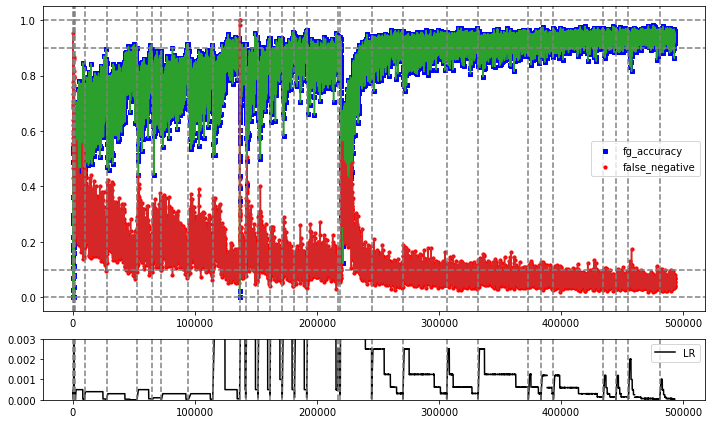

In [ ]:
#Full-length
metdf = merge_trainmetrics_files(training_df)
plot_metrics(metdf)

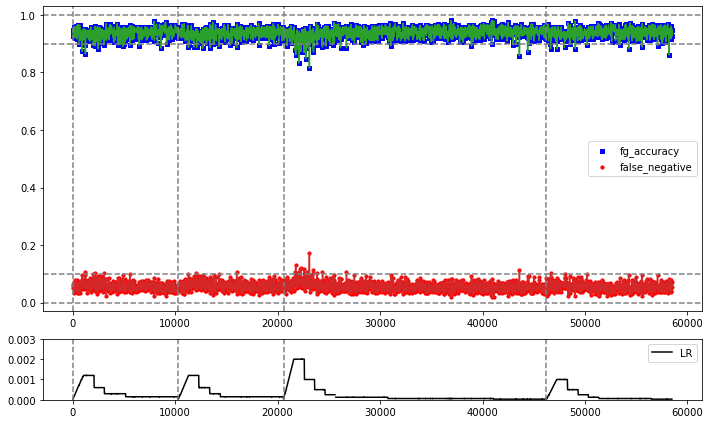

In [ ]:
#Just the most recent 4 runs
metdf_last4 = merge_trainmetrics_files(training_df_last4)
plot_metrics(metdf_last4)

This little function plots the learning rate in a panel below the most important statistics.  

In [ ]:
def plot_metrics(metdf):
    #Define x and three y series
    x = metdf['iter_global']    #.iteration
    y1 = metdf['fast_rcnn/fg_cls_accuracy']
    y2 = metdf['fast_rcnn/false_negative']
    y3 = metdf.lr

    gs = gridspec.GridSpec(2,1, height_ratios=[5, 1])
    fig = plt.figure(figsize=(10, 6)) 
    ax1 = plt.subplot(gs[0])
    ax1.scatter(x,y1, s=10, c='b', marker="s", label='fg_accuracy')
    ax1.scatter(x,y2, s=10, c='r', marker="o", label='false_negative')
    ax1.legend(loc='center right');
    ax1.plot(x, y1, color='tab:green')
    ax1.plot(x,y2,color='tab:red')
    ax1.axhline(y=0, color='gray',linestyle = 'dashed')
    ax1.axhline(y=0.1, color='gray',linestyle = 'dashed')
    ax1.axhline(y=0.9, color='gray',linestyle = 'dashed')
    ax1.axhline(y=1.0, color='gray',linestyle = 'dashed')

    #ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    ax2 = plt.subplot(gs[1])
    ax2.plot(x,y3, color='black',label='LR')
    ax2.legend(loc='upper right')
    ax2.set_ylim([0, .003])

    #Create a set of vertical lines to show where each restart is
    vlines = list(metdf[metdf['iteration']==19]['iter_global'])
    for i in range(len(vlines)):
        ax1.axvline(x=vlines[i], color='gray',linestyle = 'dashed')
        ax2.axvline(x=vlines[i], color='gray',linestyle = 'dashed')

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()